In [13]:
# Source:
# http://blog.nextgenetics.net/?e=102
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<style>
body {background-color: #fb0000 !important;}
</style>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# US Video Game Sales in Relation to Maturity Rating and Genre
## Riley Stange
### October 8, 2019

### Does a Video Game's maturity rating impact sales?

### Does the genre have an impact as well?

### If so, by how much?

<h2><center>Understanding ESRB's Ratings</center></h2>

<img align="left" style="margin-right: 20px" src="https://www.esrb.org/wp-content/uploads/2019/05/E.svg" width="100" height="170" /><br>Content is generally suitable for all ages. May contain minimal cartoon, fantasy or mild violence and/or infrequent use of mild language<br>
<img align="left" style="margin-right: 20px" src="https://www.esrb.org/wp-content/uploads/2019/05/E10plus.svg" width="100" height="170" /><br>Content is generally suitable for ages 10 and up. May contain more cartoon, fantasy or mild violence, mild language and/or minimal suggestive themes.

<img align="left" style="margin-right: 20px" src="https://www.esrb.org/wp-content/uploads/2019/05/T.svg" width="100" height="170" /><br>Content is generally suitable for ages 13 and up. May contain violence, suggestive themes, crude humor, minimal blood, simulated gambling and/or infrequent use of strong language.<br>
<img align="left" style="margin-right: 20px" src="https://www.esrb.org/wp-content/uploads/2019/05/M.svg" width="100" height="170" /><br>Content is generally suitable for ages 17 and up. May contain intense violence, blood and gore, sexual content and/or strong language.

## Since 2003, M-Rated Video Games are #2 in number of games sold

## Second only to games of the E-Rating

## 3. Data

In [3]:
# Initialize the environment
import math
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd

%matplotlib inline
sns.set(style="darkgrid")

In [4]:
sales = pd.read_csv(
    "~/projects/video-game-sales-by-maturity-rating/Video_Games_Sales_as_at_22_Dec_2016.csv"
)

In [5]:
# Only pull from entries where there are US sales
# and where there is a rating
na_sales = sales[
    (sales["NA_Sales"] > 0) & sales.Rating.notnull()
]
na_sales["NA_Sales"].count()

9174

**Source**
<br>The data is sourced from [Kaggle](https://www.kaggle.com/rush4ratio/video-game-sales-with-ratings) and contains 9,174 observations, after filtering for our criteria of video games that have sold > 0 copies in the US, and have a rating. Changed any observation with the obsolete (as of 1998) rating of 'K-A' to 'E', since they are considered equivalent.

In [6]:
na_sales["Rating"].value_counts()

E       3764
T       2650
M       1423
E10+    1328
EC         8
AO         1
Name: Rating, dtype: int64

It appears that additional filtering of the dataset is in order, as we only have one observation in the 'AO' category, and only 8 in the now (as of 2018) retired 'EC' category.

### Filtering and Exploring The Data

In [7]:
# Eliminating the sparse/irrelevant Adults Only/Early Childhood rated observations.
na_sales_e_to_m = sales[
    (sales["NA_Sales"] > 0)
    & sales.Rating.notnull()
    & (sales["Rating"] != "AO")
    & (sales["Rating"] != "EC")
]

#### Total Sales by Rating

Before going further, I will show the total sales per category to see the size of the total market in each maturity category, to determine the most profitable demographics.

In [6]:
print(
    na_sales_e_to_m["NA_Sales"]
    .groupby(na_sales_e_to_m["Rating"])
    .agg("sum")
)
print(
    "From {}-{}".format(
        na_sales_e_to_m["Year_of_Release"].min(),
        na_sales_e_to_m["Year_of_Release"].max(),
    )
)

Rating
E       1295.82
E10+     353.32
M        748.48
T        759.75
Name: NA_Sales, dtype: float64
From 1992.0-2016.0


The greatest number of sales since 1994 (since that is when the ESRB ratings system began) are found within the E rating.
<br>One factor that may be contributing to these high sales figures are past trends that may now be irrelevant for the present day market.
<br>With that in mind, I will plot the four ratings using the year of release as an X axis.

#### Line Plot Sales by Year of Release

In [34]:
def lineplot(x_array, y_array, hue_array, title, data_frame):
    sns.relplot(
        x=x_array,
        y=y_array,
        hue=hue_array,
        kind="line",
        height=10,
        aspect=1.25,
        data=data_frame,
    )
    plt.title(title)
    plt.show()

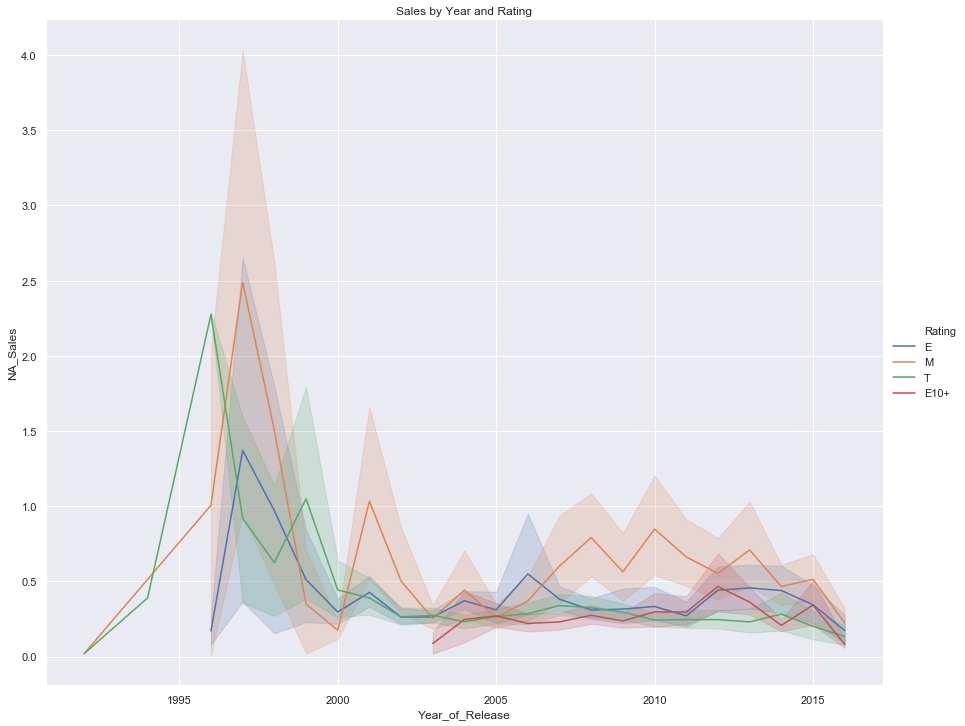

In [35]:
lineplot(
    "Year_of_Release",
    "NA_Sales",
    "Rating",
    "Sales by Year and Rating",
    na_sales_e_to_m,
)

Between 1995 and 2000, there was a massive bubble in the video game industry. Mature games seemed to be dominant in the early 2000s, and we don't see any instance of E10+ rated games until about 2003. Based on this chart, sales figures before 2003 may be creating a bias, as I intuitively felt to be true earlier. For a fair (to E10+ games) comparison, I think only using sales figures from 2003 is important, and will make the data more relevant to recent trends and customer behavior.

In [8]:
na_sales_e_to_m_since_2003 = na_sales_e_to_m[
    na_sales_e_to_m["Year_of_Release"] >= 2003
]

Now, see how this will change the total sales by genre table.

#### Sales by Rating Since 2003

In [47]:
print(
    na_sales_e_to_m_since_2003["NA_Sales"]
    .groupby(na_sales_e_to_m_since_2003["Rating"])
    .agg("sum")
)

Rating
E       1045.20
E10+     345.50
M        669.38
T        590.91
Name: NA_Sales, dtype: float64


It seems there is now a more level playing field.
<br>Now, how does the the line plot look?

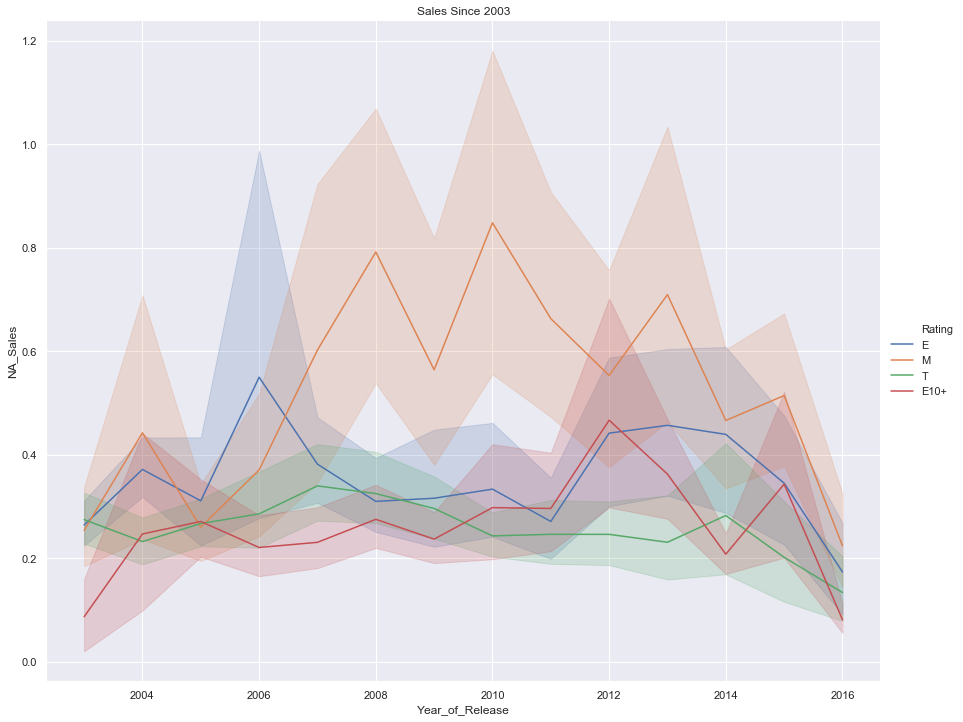

In [48]:
lineplot(
    "Year_of_Release",
    "NA_Sales",
    "Rating",
    "Sales Since 2003",
    na_sales_e_to_m_since_2003,
)

Since ~2007, Mature games seemed to do better than all the other ratings. Moreover, since ~2015, the game market in general has been bearish. 
<br>Now that it is late 2019, there is over three years of additional data. It would be helpful at a later time to try and gather this data for future analysis. However, for now, I must make do with what I have.

## 4. Methods

### 1. Does Maturity Rating Effect Sales in General?

First, I will graph the data in general to get an idea of it's distribution.

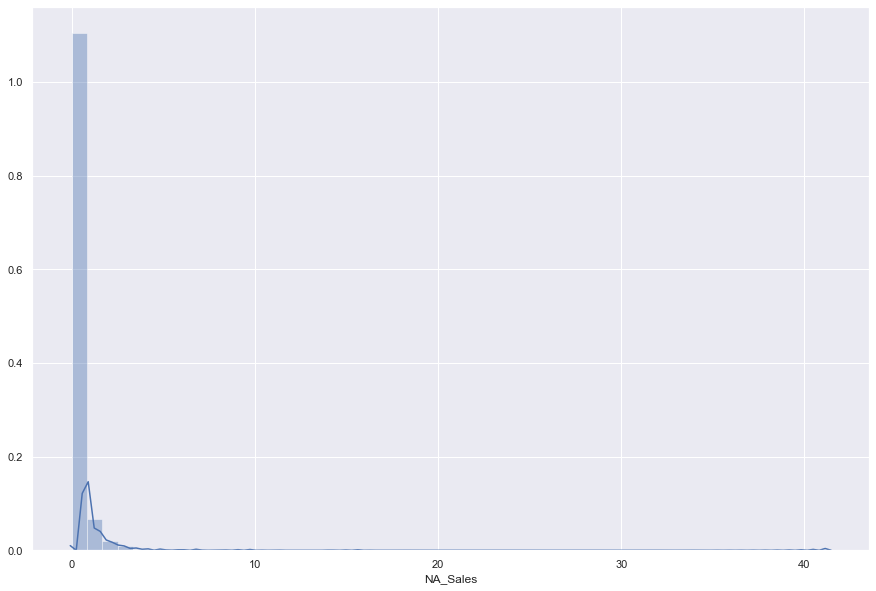

In [27]:
plt.figure(figsize=(15, 10))
sns.distplot(na_sales_e_to_m_since_2003["NA_Sales"])
plt.show()

Definitely not normal, so I do not need to do any statistical tests to confirm for normality. I will now use the Kruskal-Wallis test to see if I can refuse the null. Also I can just barely see that there is one extreme outlier that had sales of more than 40 million USD. I will look more into this later.

#### Kruskal-Wallis

In [50]:
stats.kruskal(
    na_sales_e_to_m_since_2003["NA_Sales"][
        na_sales_e_to_m_since_2003["Rating"] == "E"
    ],
    na_sales_e_to_m_since_2003["NA_Sales"][
        na_sales_e_to_m_since_2003["Rating"] == "E10+"
    ],
    na_sales_e_to_m_since_2003["NA_Sales"][
        na_sales_e_to_m_since_2003["Rating"] == "T"
    ],
    na_sales_e_to_m_since_2003["NA_Sales"][
        na_sales_e_to_m_since_2003["Rating"] == "M"
    ],
)

KruskalResult(statistic=53.64183084453436, pvalue=1.337818970653945e-11)

**Results**

From this, I can tell that at least one group is significantly different from the other three, and so for this broader null, I can reject it and move onto a more focused hypothesis and get more details on how significant those differences are, and based on what Ratings and Genres. 

### 2. Revealing Where The Differences Are, and Which Are Most Significant

First, to satisfy my own (and possibly anyone else's) curiousity, I will see what that outlier is. 

In [51]:
na_sales_e_to_m_since_2003[na_sales_e_to_m_since_2003["NA_Sales"] > 40]

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E


<br>Due to the "Wii Sports" outlier, I will make a copy of our dataset, and then clip it's sale values to 16 million, more in line with the others, to get a clearer picture of what is happening at the lower end of the plot.

In [52]:
clipped_sales = na_sales_e_to_m_since_2003.copy()
clipped_sales["NA_Sales"] = na_sales_e_to_m_since_2003[
    "NA_Sales"
].clip(upper=16)

#### Boxen Plot by Rating

I will now utilize a categorical boxen plot to give a clearer view of distribution's shape within each rating, and any outliers. 

In [53]:
def boxenplot(x_array, y_array, hue_array, data_frame, title):
    sns.catplot(
        x=x_array,
        y=y_array,
        kind="boxen",
        hue=hue_array,
        height=10,
        aspect=1.25,
        data=data_frame,
    )
    plt.title(title)
    plt.show()

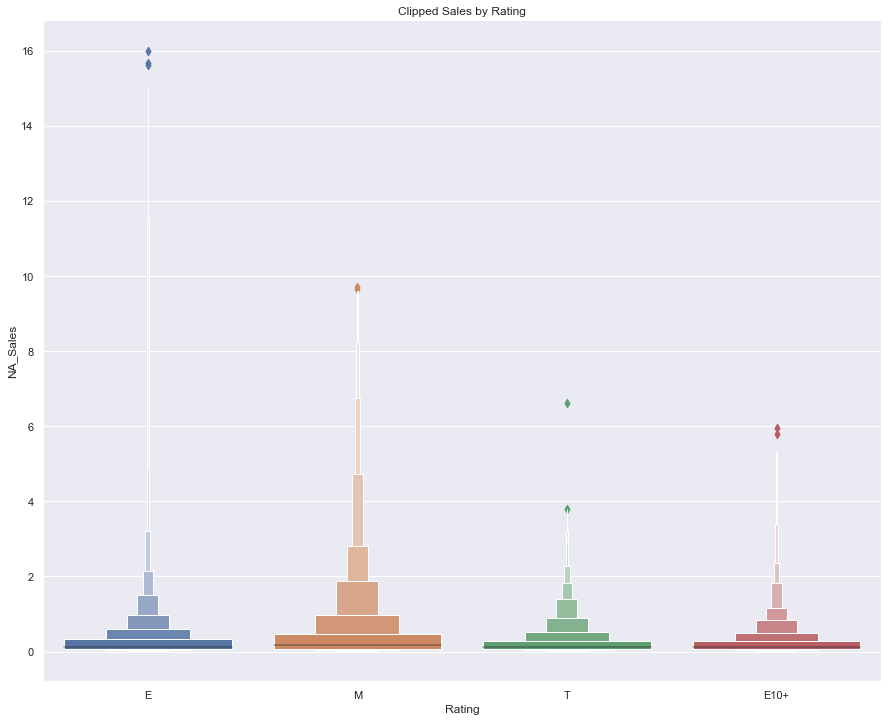

In [54]:
boxenplot(
    "Rating",
    "NA_Sales",
    None,
    clipped_sales,
    "Clipped Sales by Rating",
)

From a quick glance, I first notice that the greatest outliers are within the E rating. However, it appears there is a lot of activity going on in the Mature rated category. 

#### Tukey HSD Test

Now I will perform the Tukey HSD test to compare the differences between the different ratings.

In [55]:
tukey_rating = pairwise_tukeyhsd(
    endog=na_sales_e_to_m_since_2003["NA_Sales"],  # Data
    groups=na_sales_e_to_m_since_2003["Rating"],  # Groups
    alpha=0.05, # Significance level
)
tukey_rating.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
E,E10+,-0.0812,0.025,-0.1553,-0.0072,True
E,M,0.1737,0.001,0.0993,0.2481,True
E,T,-0.0754,0.011,-0.1382,-0.0126,True
E10+,M,0.255,0.001,0.1671,0.3428,True
E10+,T,0.0058,0.9,-0.0724,0.0841,False
M,T,-0.2491,0.001,-0.3277,-0.1706,True


**Results**

Based on these results, we can reject the null in every case, except for comparing the differences of the means of E10+ and T ratings sales.
<br>The most significant differences in means are seen between: E10+-M, M-T, and E-M.
<br>

### 3. Best Performing Genres for Mature Rated Games

#### Exploration

After getting an idea of the big picture of where the greatest differences are in means sales between genres, I will now take a quick look at the total sales (since 2003) of games by genre, in order to see where I should focus my attention.

In [56]:
print(
    na_sales_e_to_m_since_2003["NA_Sales"]
    .groupby(na_sales_e_to_m_since_2003["Genre"])
    .agg("sum")
)

Genre
Action          570.90
Adventure        58.20
Fighting        111.87
Misc            278.62
Platform        170.58
Puzzle           45.86
Racing          188.17
Role-Playing    189.70
Shooter         415.91
Simulation      120.72
Sports          468.11
Strategy         32.35
Name: NA_Sales, dtype: float64


The Action genre is the clear winner here, with over 100 million more in sales than the second largest (Sports) since 2003.

##### Boxen Plot

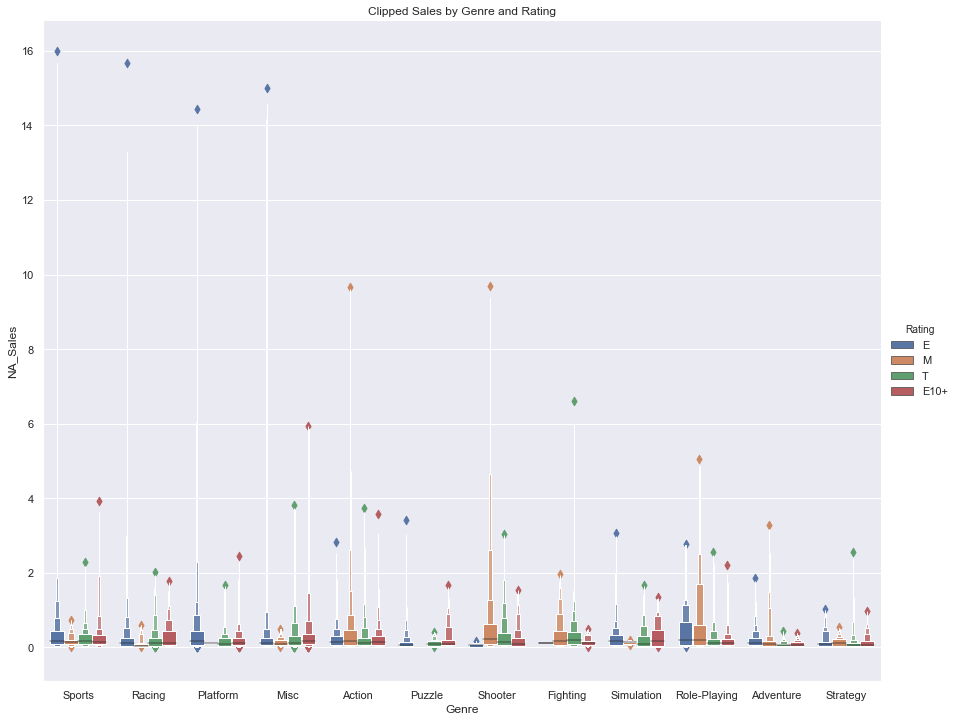

In [57]:
boxenplot(
    "Genre",
    "NA_Sales",
    "Rating",
    clipped_sales,
    "Clipped Sales by Genre and Rating",
)

While the Action market is larger, it appears that M-Rated Shooters do much better. This will make for a veritable clash of the titans later!

#### 1. Action Game Sales by Rating

##### Exploration

###### Swarm Plot

Since the number of observations is now smaller, I can now utilize a swarm plot to get a clearer picture of all the data points within each rating.

In [58]:
def swarmplot(array_x, array_y, data_frame, title):
    sns.catplot(
        x=array_x,
        y=array_y,
        kind="swarm",
        height=10,
        aspect=1.25,
        data=data_frame,
    )
    plt.title(title)
    plt.show()

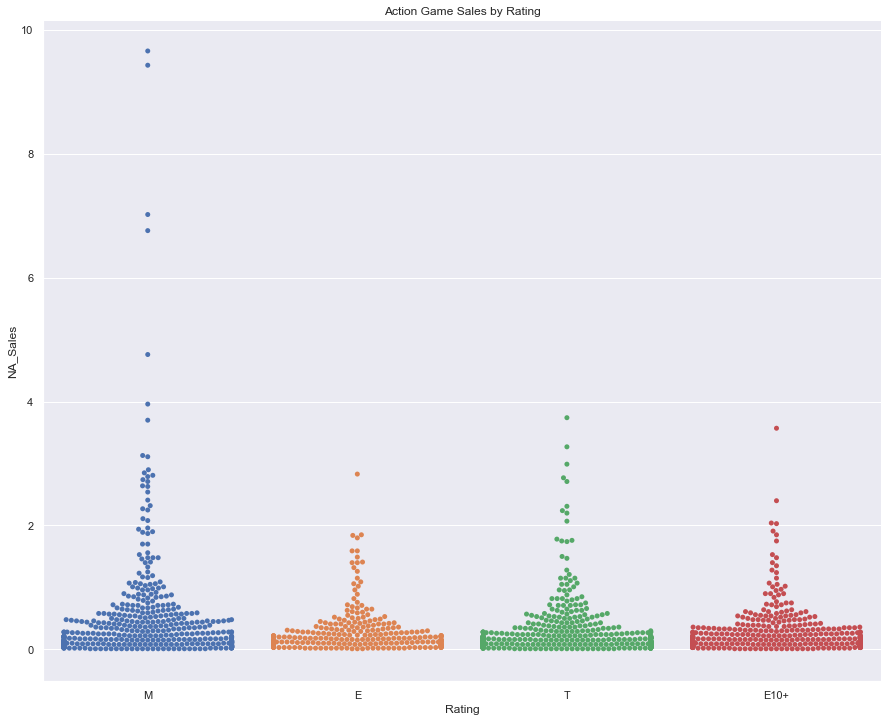

In [59]:
action = na_sales_e_to_m_since_2003[
    na_sales_e_to_m_since_2003["Genre"] == "Action"
]
swarmplot(
    "Rating",
    "NA_Sales",
    action,
    "Action Game Sales by Rating",
)

Seems to be more balanced than the earlier overall boxenplot with all genres together.

###### Kruskal-Wallis

In [60]:
stats.kruskal(
    action["NA_Sales"][action["Rating"] == "E"],
    action["NA_Sales"][action["Rating"] == "E10+"],
    action["NA_Sales"][action["Rating"] == "T"],
    action["NA_Sales"][action["Rating"] == "M"],
)

KruskalResult(statistic=22.71165659877555, pvalue=4.637514516335985e-05)

Yes, the test statistic is less than half of that than when all of the genres are compared, and the confidence level, while still far lower than 0.05, is significantly higher than before. So I have a more interesting set of observations to compare for mean differences using the Tukey HSD.

###### Tukey HSD

In [61]:
tukey_action = pairwise_tukeyhsd(
    endog=action["NA_Sales"],  # Data
    groups=action["Rating"],  # Groups
    alpha=0.05, # Significance level
)
tukey_action.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
E,E10+,-0.0023,0.9,-0.1158,0.1113,False
E,M,0.2059,0.001,0.0959,0.316,True
E,T,-0.0034,0.9,-0.1129,0.1061,False
E10+,M,0.2082,0.001,0.1091,0.3074,True
E10+,T,-0.0011,0.9,-0.0997,0.0975,False
M,T,-0.2094,0.001,-0.3039,-0.1148,True


E-E10+, E-T, and E10+-T rated Action games all have similar sales numbers.
<br>What is interesting is how the mean difference between all the other ratings to Mature are very similar, within the low 200K USD amount.
<br>Since the differences are so similar, I will put them into two groups:

**M-Rated Action Games
<br>Non-M-Rated Action Games**

##### Hypothesis

$H_0$: There is **no** significant difference in mean sales between Mature rated Action games and Action games of another rating.

$H_A$: There **is a** significant difference in mean sales between Mature rated Action games and Action games of another rating.

##### Method

In [62]:
def get_95_ci(array_1, array_2):
    sample_1_n = array_1.shape[0]
    sample_2_n = array_2.shape[0]
    sample_1_mean = array_1.mean()
    sample_2_mean = array_2.mean()
    sample_1_var = array_1.var()
    sample_2_var = array_2.var()
    mean_difference = sample_2_mean - sample_1_mean
    std_err_difference = math.sqrt(
        (sample_1_var / sample_1_n)
        + (sample_2_var / sample_2_n)
    )
    margin_of_error = 1.96 * std_err_difference
    ci_lower = mean_difference - margin_of_error
    ci_upper = mean_difference + margin_of_error
    return (
        "The difference in means at the 95% confidence interval (two-tail) is between "
        + str(ci_lower)
        + " and "
        + str(ci_upper)
        + "."
    )

In [63]:
m_action = action[action["Rating"] == "M"
]
other_action = action[action["Rating"] != "M"]
print(
    get_95_ci(
        other_action["NA_Sales"], m_action["NA_Sales"]
    )
)
print()
print("Mean Sales: By Millions")
print(
    action["NA_Sales"]
    .groupby(action["Rating"])
    .agg("mean")
)

The difference in means at the 95% confidence interval (two-tail) is between 0.12546860680471184 and 0.2908345347443314.

Mean Sales: By Millions
Rating
E       0.259612
E10+    0.257324
M       0.465560
T       0.256196
Name: NA_Sales, dtype: float64


I can see that, with 95% confidence, that Mature rated Action games sell between ~125K and ~290K USD more than Action games with another rating, with the mean M-Rated Action game total sales coming in at ~465K USD, more than double the mean sales of every other rating category, ranging from ~256-259K USD. Now it is up to further research to see what makes Mature rated Action games sell more than the others. Since games in this genre usually involve adrenaline pumping, high intensity gameplay, more realistic violence would make sense to supplement the experience that defines this genre.

#### 2. Shooter Sales by Rating

##### Exploration

From earlier, I saw that it appears Mature rated games do well in this genre. I will do a similar analysis as I did earlier with the Action genre.

###### Swarm Plot

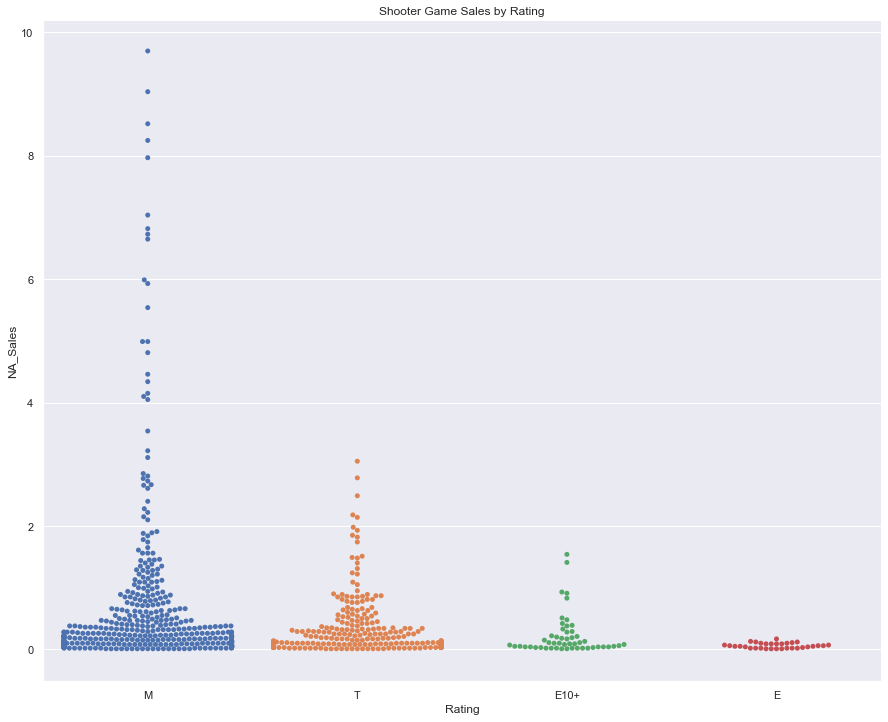

In [64]:
shooters = na_sales_e_to_m_since_2003[
    na_sales_e_to_m_since_2003["Genre"] == "Shooter"
]
swarmplot(
    "Rating",
    "NA_Sales",
    shooters,
    "Shooter Game Sales by Rating",
)

In [65]:
print()
print("Total Sales: By Millions")
print(
    shooters["NA_Sales"]
    .groupby(shooters["Rating"])
    .agg("sum")
)


Total Sales: By Millions
Rating
E         1.95
E10+     11.64
M       313.89
T        88.43
Name: NA_Sales, dtype: float64


Mature rated shooters clearly have a larger market, and a lot more breakout hits, while only Teen rated shooters seem to be anywhere close in success.

###### Kruskal-Wallis Test

In [66]:
stats.kruskal(
    shooters["NA_Sales"][shooters["Rating"] == "E"],
    shooters["NA_Sales"][shooters["Rating"] == "E10+"],
    shooters["NA_Sales"][shooters["Rating"] == "T"],
    shooters["NA_Sales"][shooters["Rating"] == "M"],
)

KruskalResult(statistic=54.537716041204334, pvalue=8.616460015527376e-12)

The Kruskal-Wallis test confirms that there is a significant difference in the means with at least one group from the others.

###### Tukey HSD Test

In [67]:
tukey_shooter = pairwise_tukeyhsd(
    endog=shooters["NA_Sales"],  # Data
    groups=shooters["Rating"],  # Groups
    alpha=0.05, # Significance level
)
tukey_shooter.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
E,E10+,0.1673,0.8954,-0.4528,0.7874,False
E,M,0.617,0.0089,0.1144,1.1196,True
E,T,0.2779,0.5058,-0.2371,0.7929,False
E10+,M,0.4497,0.0229,0.044,0.8554,True
E10+,T,0.1106,0.9,-0.3104,0.5316,False
M,T,-0.3391,0.001,-0.552,-0.1263,True


Since there is no significant difference in the means of all the other groups, except when comparing against M rated shooters, I will make them into two groups:

**M-Rated Shooters
<br>Non-M-Rated Shooters**

##### Hypothesis

$H_0$: There is **no** significant difference in mean sales between Mature rated Shooters and Shooters of another rating.

$H_A$: There **is a** significant difference in mean sales between Mature rated Shooters and Shooters of another rating.

##### Method

In [68]:
m_shooters = shooters[
    shooters["Rating"] == "M"
]
other_shooters = shooters[
    shooters["Rating"] != "M"
]
print(
    get_95_ci(
        other_shooters["NA_Sales"], m_shooters["NA_Sales"]
    )
)
print()
print("Mean Sales: By Millions")
print(
    shooters["NA_Sales"]
    .groupby(shooters["Rating"])
    .agg("mean")
)

The difference in means at the 95% confidence interval (two-tail) is between 0.24901514656319132 and 0.5137416468468241.

Mean Sales: By Millions
Rating
E       0.060938
E10+    0.228235
M       0.677948
T       0.338812
Name: NA_Sales, dtype: float64


With a 95% confidence interval (two-tail) M-Rated shooters sell between ~249K and ~513K USD more than non-M-Rated shooters, with the mean M-Rated shooter total sales coming in at ~677K USD, more than double the mean sales of a Teen rated shooter at ~338K USD. Now it is up to further research to see what makes Mature Rated shooters sell more than the others. Perhaps the target audience of shooters prefer greater degrees of realism in violence that cannot be found in a rating lower than Mature? One of the defining aspects of the Shooter genre is that you are immersed in the first person, and perhaps, unrealistic violence would be detrimental to that immersive experience that most buyers in that market are looking for.

### 4. Battle of the Titans: M-Rated Action vs M-Rated Shooter

#### Exploration

##### Swarm Plot

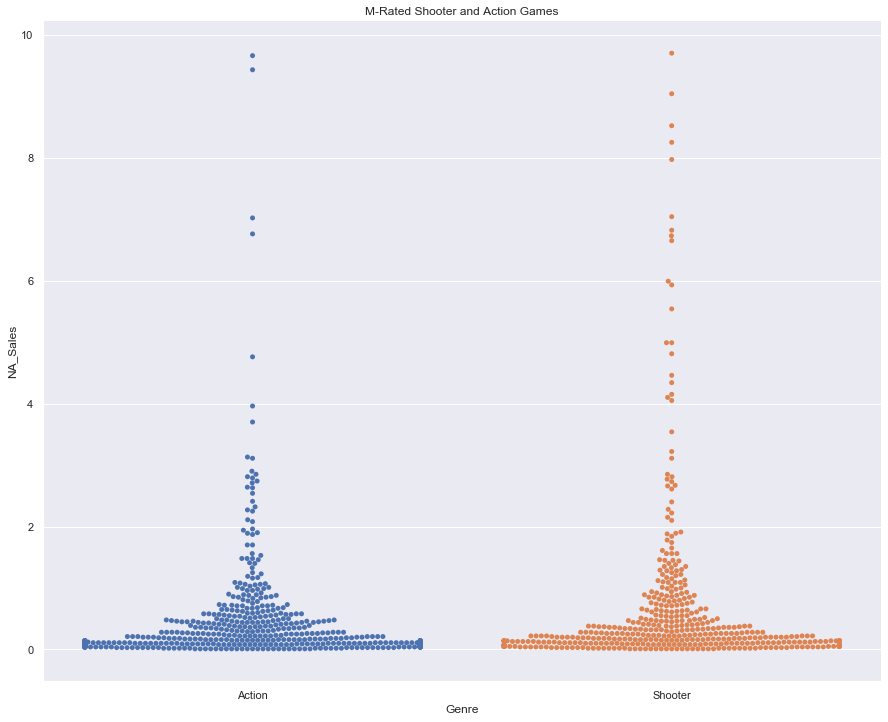

In [70]:
titans = m_action.append(m_shooters)
swarmplot(
    "Genre",
    "NA_Sales",
    titans,
    "M-Rated Shooter and Action Games",
)

Similar, but it appears the Shooters have more best sellers above 4 million USD.

#### Hypothesis

$H_0$: There is **no** significant difference in mean sales between M-rated Action games and M-Rated Shooters.

$H_A$: There **is a** significant difference in mean sales between M-rated Action games and M-Rated Shooters.

#### Method

##### Tukey HSD Test
Since there are only two groups, I will skip straight to the Tukey HSD test.

In [170]:
tukey_titans = pairwise_tukeyhsd(
    endog=titans["NA_Sales"],  # Data
    groups=titans["Genre"],  # Groups
    alpha=0.05, # Significance level
)
tukey_titans.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Action,Shooter,0.2124,0.004,0.0681,0.3567,True


Shooters sell for over 212K USD, according to this test of the mean difference.
<br>Now to confirm with the 95% Confidence Interval test.

##### 95% Confidence Test

In [177]:
action_titan = titans[titans["Genre"] == "Action"
]
shooter_titan = titans[titans["Genre"] == "Shooter"
]
print(
    get_95_ci(
        action_titan["NA_Sales"], shooter_titan["NA_Sales"]
    )
)
print()
print("Mean Sales: By Millions")
print(
    titans["NA_Sales"]
    .groupby(titans["Genre"])
    .agg("mean")
)

The difference in means at the 95% confidence interval (two-tail) is between 0.06532778637675712 and 0.3594488507972881.

Mean Sales: By Millions
Genre
Action     0.465560
Shooter    0.677948
Name: NA_Sales, dtype: float64


#### Results

With 95% confidence, M-Rated Shooters sell between 65K-359K more on average than M-Rated Action games. While the low end may not seem like much, the higher end is more significant, and with the Tukey test, I found it to come right about in the middle at ~212K USD. These insights can be the difference between a studio choosing to make a Shooter, or an Action game, or what kind of project a publisher is looking for that a studio is already working on.

## 5. Overall Results, Discussion and Recommendation

### 1. Summary

In general, since 2003, M-Rated video games have been the second largest grossing market in the video game industry, second only to E-rated games that have the advantage of mass-appeal, and several wildly successful outliers, with the outlier's combined sales totaling to almost 100 million USD. 

### 2 Discussion and Recommendation

The most successful titles in the Action and Shooter categories categories have things in common that are easy to replicate and understand: Buyers want their violence as realistic as possible. They want action, and they want to shoot things: So they don't want the realism to be watered down. 
<br>In the instance of Shooters, this is even more important, since they are usually played in a first-person perspective, whereas Action games are usually third-person, so less-realistic violence does not seem to have as much of an affect on sales.
<br>Studying the sentiments of gamers within these genres would be very helpful in understanding further why they mostly purchase M-Rated titles in these two genres. Perhaps doing a group study across a demographic of say 17-45, would be helpful in getting feedback about what they like and dislike about games of varying maturity levels within these genres.
<br>Further research on this comparison in other genres would also be helpful, especially for Role-Playing Games and (to a lesser degree) Fighting games, as seen earlier in the boxen plot at the beginning of this notebook.
<br>It is clear that the development of a video game takes a lot of time and effort, that which must be focused on the right kind of gameplay and content.